In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hakgyunhong","key":"642a29cf8d9f8eb2897d6757b742acca"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets list -s english-french

ref                                                         title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
dhruvildave/en-fr-translation-dataset                       English-French Translation Dataset                  3GB  2021-02-09 19:27:52           1805         41  1.0              
devicharith/language-translation-englishfrench              Language Translation (English-French)               4MB  2020-04-08 11:35:32           1538         35  0.8235294        
digvijayyadav/frenchenglish                                 English to French translations                      6MB  2020-07-27 16:22:20            386         19  1.0              
jannesklaas/frenchenglish-bilingual-pairs                   French-English Bilingual Pairs

In [5]:
!kaggle datasets download -d wkirgsn/electric-motor-temperature

 96% 112M/117M [00:06<00:00, 28.9MB/s]
100% 117M/117M [00:07<00:00, 17.4MB/s]


In [6]:
!unzip electric-motor-temperature.zip
!ls

Archive:  electric-motor-temperature.zip
  inflating: measures_v2.csv         
electric-motor-temperature.zip	kaggle.json  measures_v2.csv  sample_data


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import os

# Data Import

In [8]:
df=pd.read_csv('/content/measures_v2.csv')
df.columns

Index(['u_q', 'coolant', 'stator_winding', 'u_d', 'stator_tooth',
       'motor_speed', 'i_d', 'i_q', 'pm', 'stator_yoke', 'ambient', 'torque',
       'profile_id'],
      dtype='object')

In [9]:
target_features = ['pm', 'stator_tooth', 'stator_yoke', 'stator_winding']
df.shape

(1330816, 13)

In [10]:
df.describe()

u_q       coolant  stator_winding           u_d  stator_tooth  \
count  1.330816e+06  1.330816e+06    1.330816e+06  1.330816e+06  1.330816e+06   
mean   5.427900e+01  3.622999e+01    6.634275e+01 -2.513381e+01  5.687858e+01   
std    4.417323e+01  2.178615e+01    2.867206e+01  6.309197e+01  2.295223e+01   
min   -2.529093e+01  1.062375e+01    1.858582e+01 -1.315304e+02  1.813398e+01   
25%    1.206992e+01  1.869814e+01    4.278796e+01 -7.869090e+01  3.841601e+01   
50%    4.893818e+01  2.690014e+01    6.511013e+01 -7.429755e+00  5.603635e+01   
75%    9.003439e+01  4.985749e+01    8.814114e+01  1.470271e+00  7.558668e+01   
max    1.330370e+02  1.015985e+02    1.413629e+02  1.314698e+02  1.119464e+02   

        motor_speed           i_d           i_q            pm   stator_yoke  \
count  1.330816e+06  1.330816e+06  1.330816e+06  1.330816e+06  1.330816e+06   
mean   2.202081e+03 -6.871681e+01  3.741278e+01  5.850678e+01  4.818796e+01   
std    1.859663e+03  6.493323e+01  9.218188e+01  1.900150e+01  1.999100e+01   
min   -2.755491e+02 -2.780036e+02 -2.934268e+02  2.085696e+01  1.807669e+01   
25%    3.171107e+02 -1.154061e+02  1.095863e+00  4.315158e+01  3.199033e+01   
50%    1.999977e+03 -5.109376e+01  1.577401e+01  6.026629e+01  4.562551e+01   
75%    3.760639e+03 -2.979688e+00  1.006121e+02  7.200837e+01  6.146083e+01   
max    6.000015e+03  5.189670e-02  3.017079e+02  1.136066e+02  1.011480e+02   

            ambient        torque    profile_id  
count  1.330816e+06  1.330816e+06  1.330816e+06  
mean   2.456526e+01  3.110603e+01  4.079306e+01  
std    1.929522e+00  7.713575e+01  2.504549e+01  
min    8.783478e+00 -2.464667e+02  2.000000e+00  
25%    2.318480e+01 -1.374265e-01  1.700000e+01  
50%    2.479733e+01  1.086035e+01  4.300000e+01  
75%    2.621702e+01  9.159718e+01  6.500000e+01  
max    3.071420e+01  2.610057e+02  8.100000e+01

> - For Checking Numerical data property

In [11]:
df.head(5)

u_q    coolant  stator_winding       u_d  stator_tooth  motor_speed  \
0 -0.450682  18.805172       19.086670 -0.350055     18.293219     0.002866   
1 -0.325737  18.818571       19.092390 -0.305803     18.294807     0.000257   
2 -0.440864  18.828770       19.089380 -0.372503     18.294094     0.002355   
3 -0.327026  18.835567       19.083031 -0.316199     18.292542     0.006105   
4 -0.471150  18.857033       19.082525 -0.332272     18.291428     0.003133   

        i_d       i_q         pm  stator_yoke    ambient    torque  profile_id  
0  0.004419  0.000328  24.554214    18.316547  19.850691  0.187101          17  
1  0.000606 -0.000785  24.538078    18.314955  19.850672  0.245417          17  
2  0.001290  0.000386  24.544693    18.326307  19.850657  0.176615          17  
3  0.000026  0.002046  24.554018    18.330833  19.850647  0.238303          17  
4 -0.064317  0.037184  24.565397    18.326662  19.850639  0.208197          17

# Measurement session length

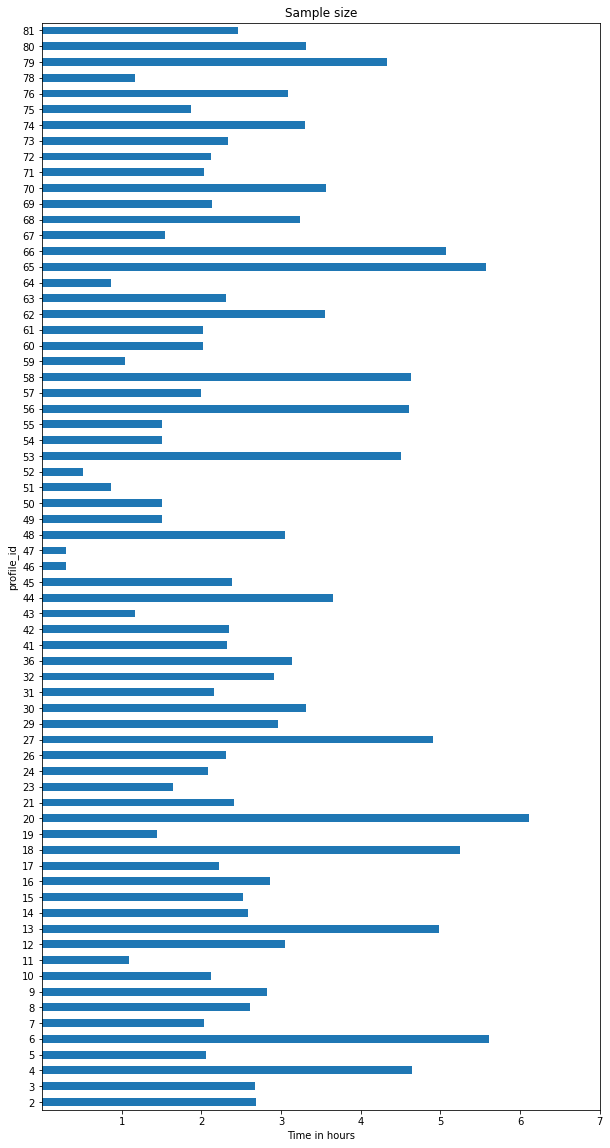

In [12]:
p_counts = df.groupby('profile_id')['pm'].agg('count')
ax=p_counts.plot.barh(figsize=(10,20), title='Sample size')

_ = ax.set_xticks(2*3600*np.arange(1,8))
_ = ax.set_xticklabels(list(range(1,8)))
_ = ax.set_xlabel('Time in hours')

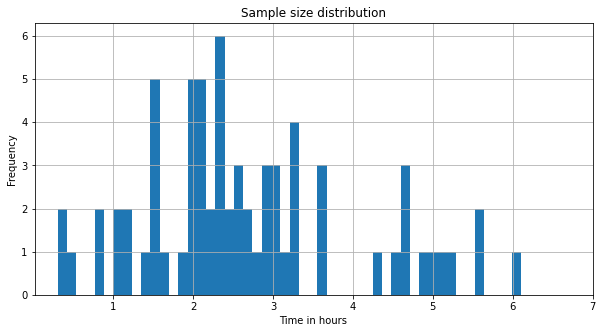

In [13]:
ax = p_counts.plot.hist(title='Sample size distribution', bins =50, figsize=(10,5), grid=True)
_ = ax.set_xticks(2*3600*np.arange(1,8))
_ = ax.set_xticklabels(list(range(1,8)))
_ = ax.set_xlabel('Time in hours')

# Linear Correlations

<ipython-input-14-7f12afbf423c>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


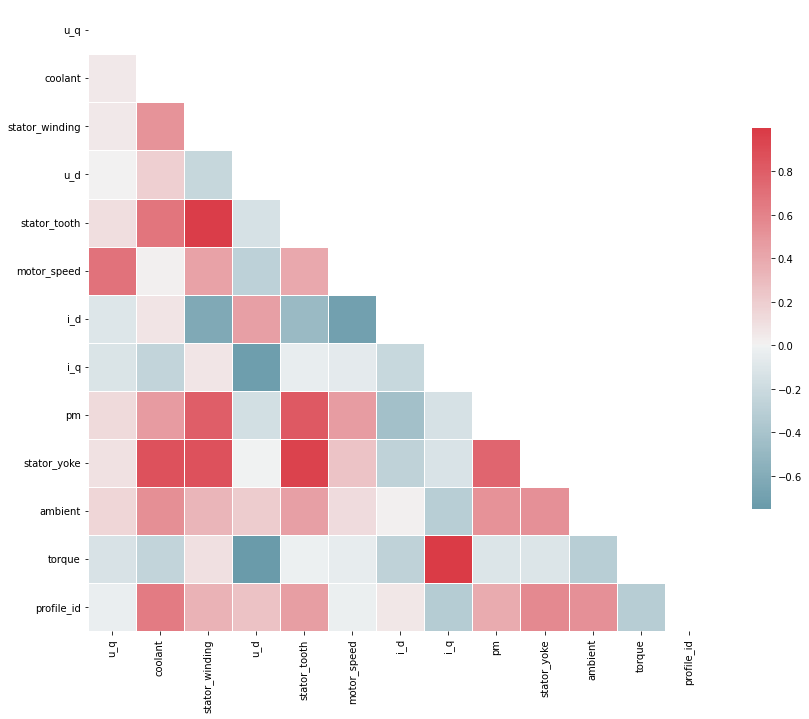

In [14]:
corr = df.corr()

mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(220,10,as_cmap = True)

plt.figure(figsize=(14,14))
_ = sns.heatmap(corr, mask=mask, cmap=cmap, center=0, 
                square=True, linewidths=.5, cbar_kws={"shrink":.5})


# Distributions

In [15]:
from matplotlib.colors import rgb2hex

In [16]:
dfui = df.drop(['profile_id'], axis=1)

/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

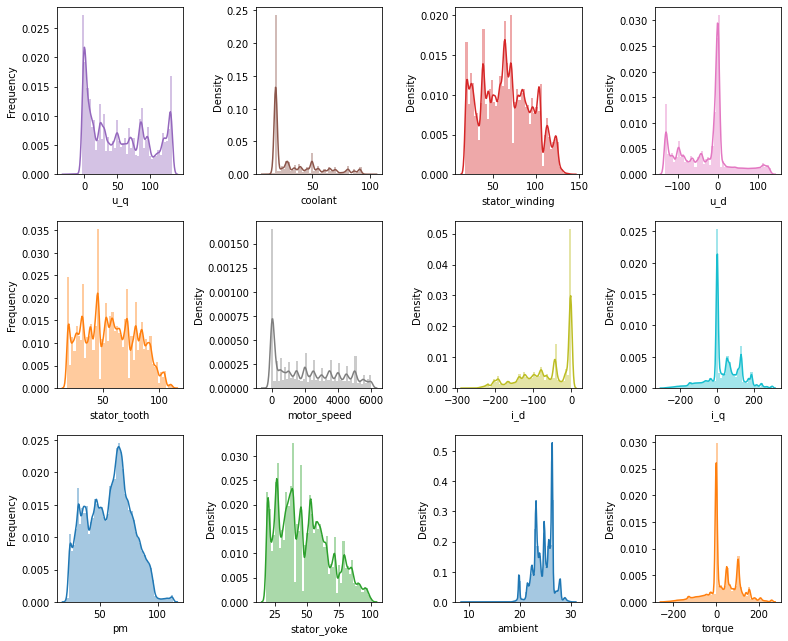

In [17]:
color_list = plt.cm.tab10(np.linspace(0,1,10)[list(range(10))+[0,1] ])

coi = target_features + [c for c in dfui if c not in target_features] # column of interest
feat_clrs = {k:rgb2hex(color_list[i][:3]) for i,k in enumerate(coi)} if color_list is not None else {}

n_cols = 4
n_rows = np.ceil(dfui.shape[1]/n_cols).astype(int)
fig,axes = plt.subplots(n_rows, n_cols, figsize=(2.8*n_cols, n_rows*3))
for i, (ax,col) in enumerate(zip(axes.flatten(), list(dfui.columns))):
  sns.distplot(dfui[col], color = feat_clrs[col], ax=ax)
  if i%n_cols ==0:
    ax.set_ylabel('Frequency')
    plt.tight_layout()

**From Here**
> - distributions are not gaussian
> - we often haave multi-modal distributions
> - some features show a significant spike in their distribution. This is reasonable as these are the values that are held during no excitation . -> (Resting, Cooldown Phase)
> - Target temperature are less spikey. Indicating a slower progress or response to input features(Read 'greater time constants')

# Time serires gestalt

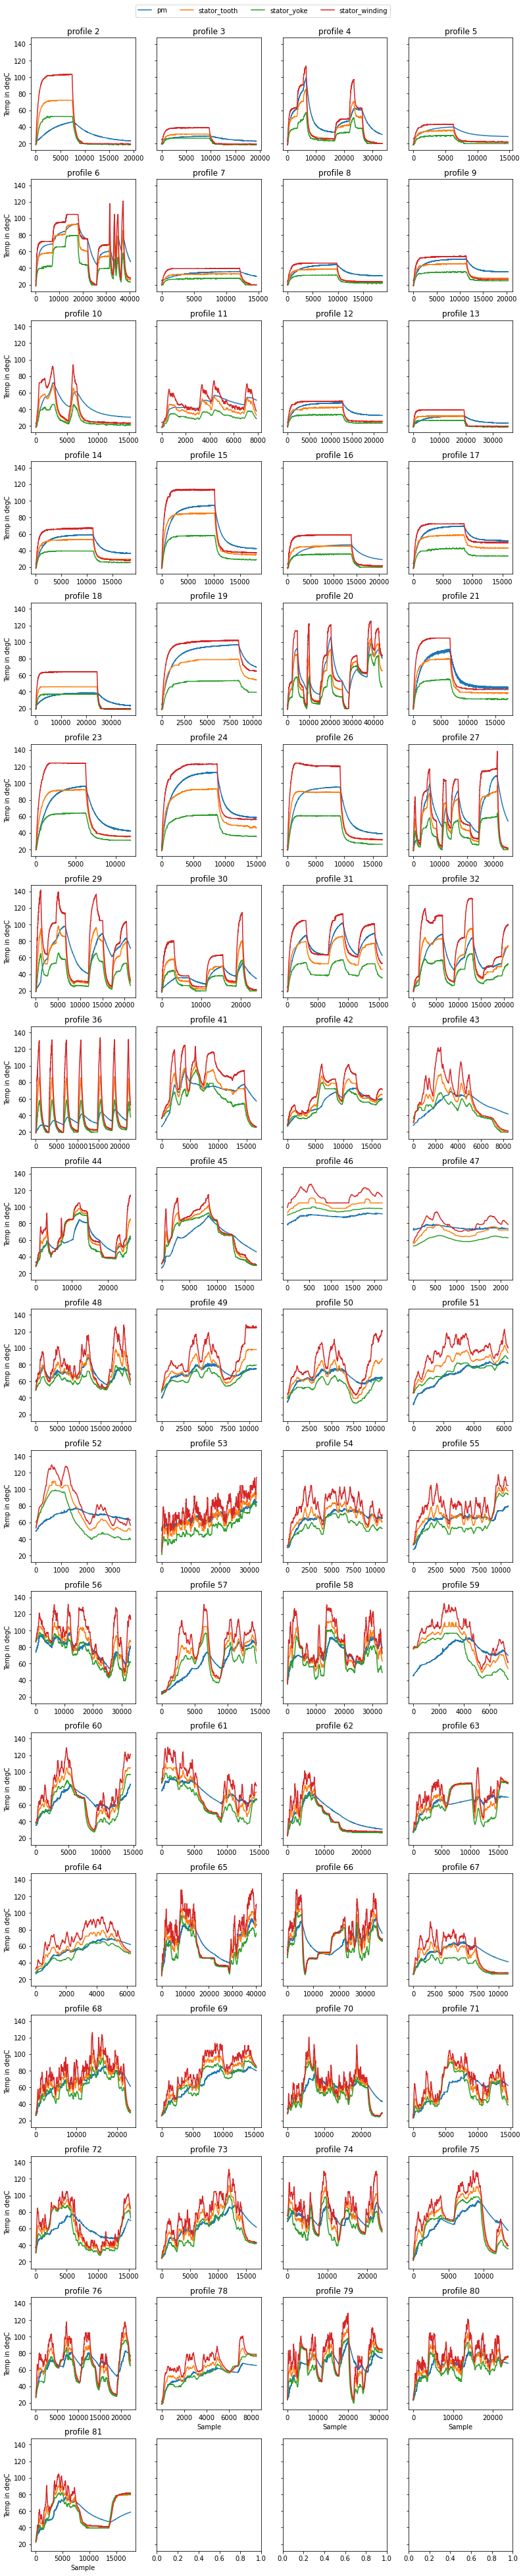

In [18]:
grpd = {pid: df_ for pid, df_ in df.groupby('profile_id')}
coi = target_features
n_cols = 4
n_rows = np.ceil(len(grpd)/n_cols).astype(int)
fig, axes = plt.subplots(n_rows,n_cols, sharey=True, figsize=(2.8*n_cols, n_rows*3))

for i, (ax, (p_id,df_)) in enumerate(zip(axes.flatten(), grpd.items())):
  for c in coi:
    lines = ax.plot(df_[c].reset_index(drop=True), label=c, color = feat_clrs[c])
    ax.set_title(f'profile {p_id}')
    if i%n_cols == 0:
      ax.set_ylabel('Temp in degC')
    if i >= (len(grpd) - n_cols):
      ax.set_xlabel('Sample')
fig.tight_layout()
_ = ax.legend(ncol=15, loc='lower center', bbox_to_anchor=(.5,1), bbox_transform=fig.transFigure)


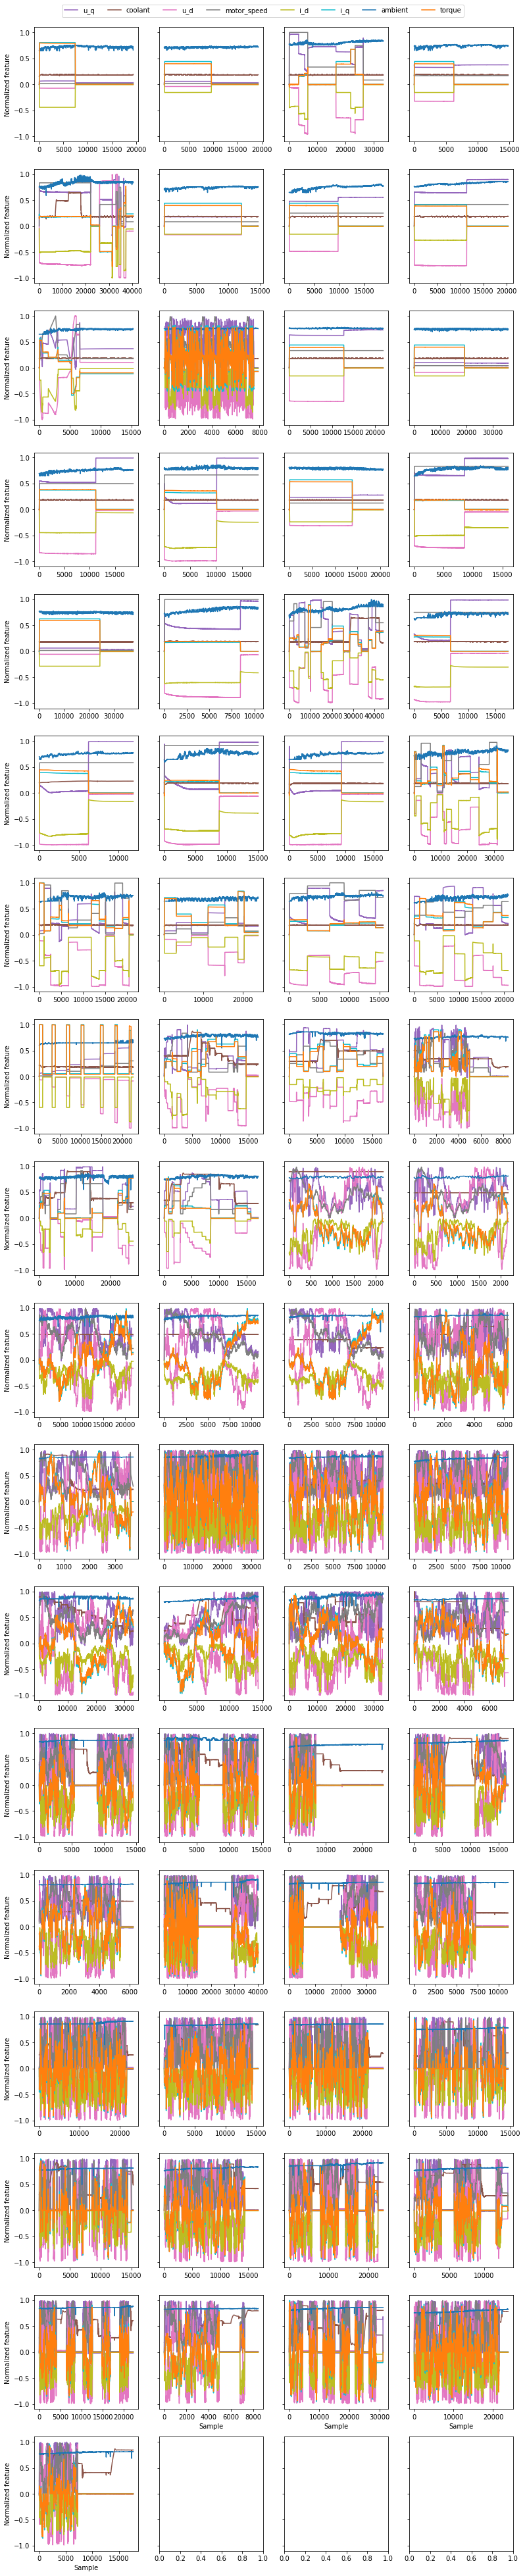

In [19]:
coi = [c for c in dfui if c not in target_features +['profile_id']]
max_values_per_col = dfui.abs().max(axis=0)
fig, axes = plt.subplots(n_rows, n_cols, sharey=True, figsize=(2.8*n_cols, n_rows*3))

for i, (ax,(p_id, df_)) in enumerate(zip(axes.flatten(), grpd.items())):
  for c in coi:
    lines = ax.plot(df_[c].reset_index(drop=True)/max_values_per_col[c], label=c,color=feat_clrs[c])
  if i % n_cols ==0:
    ax.set_ylabel('Normalized feature')
  if i>= (len(grpd)- n_cols):
    ax.set_xlabel('Sample')
fig.tight_layout()
_ = ax.legend(ncol=15, loc='lower center', bbox_to_anchor=(.5,1),bbox_transform=fig.transFigure)



- While motor excitations (motor_speed, torque, coolant) are sometimes of high dynamic, sometimes of stepwise nature, target temperatures always exhibit low-pass behavior with exponential rise and falls,
- Coolant temperature suffers from measurement artefacts expressed by sharp drops in temperature, which recover as fast,
- PM (Permanent Magnet -> Rotor) temperature expresses the slowest time constant and follows stator temperatures
- Motor_speed and torque (the excitation features) follow sometimes step-wise cycles, sometimes random walks
- Some profiles denote resting phases, where all input features stay constant most of the time

# Operation points

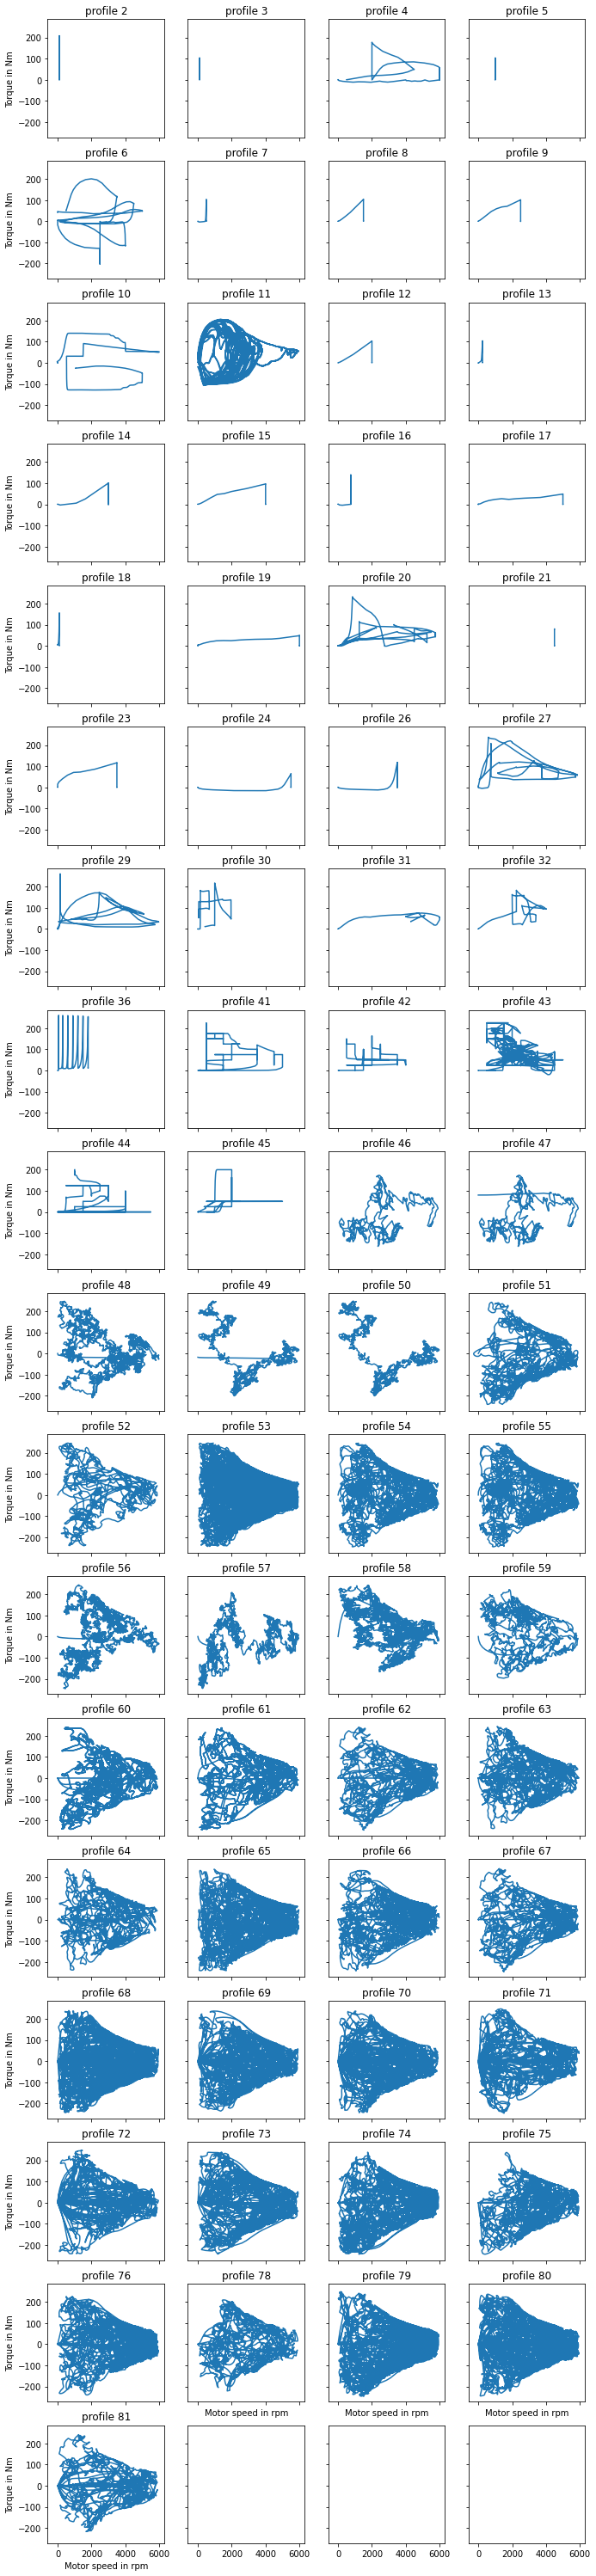

In [20]:
fig, axes = plt.subplots(n_rows, n_cols, sharey=True, sharex=True, figsize=(2.8*n_cols,n_rows*3))
for i, (ax, (p_id,df_)) in enumerate(zip(axes.flatten(), grpd.items())):
  ax.plot(df_.motor_speed, df_.torque)
  ax.set_title(f'profile {p_id}')
  if i%n_cols==0:
    ax.set_ylabel('Torque in Nm')
  if i>=len(grpd)- n_cols:
    ax.set_xlabel('Motor speed in rpm')



In [21]:
#import seaborn as sns

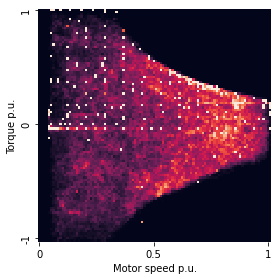

In [22]:
N_BINS=100

dfui = df.assign(binned_torque = pd.cut(df.torque.values.ravel(), bins=N_BINS, include_lowest=True),
                 binned_speed=pd.cut(df.motor_speed.values.ravel(), bins=N_BINS, include_lowest=True))

ts_map = dfui.loc[:,['binned_torque', 'binned_speed','torque']].groupby(['binned_torque','binned_speed']).count().fillna(0).reset_index().rename(columns={'torque':'count'}).pivot(index='binned_torque', columns='binned_speed',values='count').sort_values('binned_torque',ascending=False)


plt.figure(figsize=(6,4))

ax = sns.heatmap(ts_map, robust=True, square=True, yticklabels=49, xticklabels=49, cbar=False)
_ = ax.set_ylabel('Torque p.u.')
_ = ax.set_xlabel('Motor speed p.u.')
_ = ax.set_xticklabels([0, 0.5, 1], rotation=0)
_ = ax.set_yticklabels([1, 0, -1])

plt.tight_layout()



                 

# Dimensionality reduced visualization

rows: 7


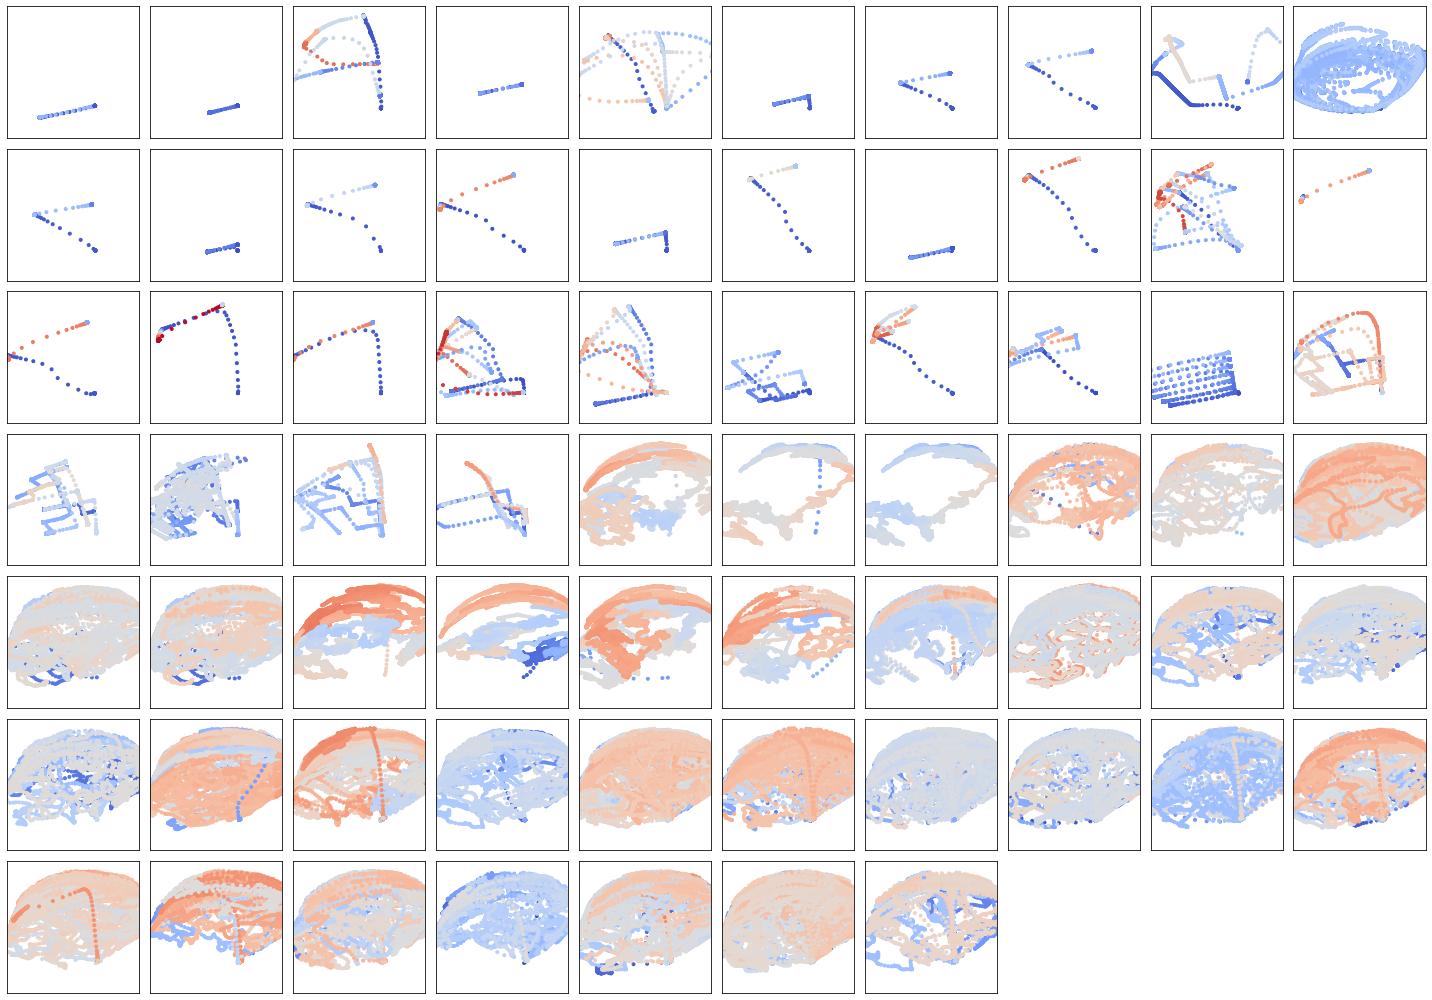

In [26]:
_df = df.loc[~df.profile_id.isin([46,47])].reset_index(drop=True)
_df = _df/_df.abs().max(axis=0)

transformed = PCA().fit_transform(_df.drop(['profile_id'] + target_features, axis=1))
N = len(_df.profile_id.unique())
cols = min(10,N)
rows = int(np.ceil(N/10))
plt.figure(figsize=(2*cols,2*rows))

print("rows:", rows)

for i , (sess_id, sess_df) in enumerate(_df.groupby(['profile_id'])):
  plt.subplot(rows, cols, i+1)
  _trans = transformed[sess_df.index, :]
  plt.scatter(_trans[:,0], _trans[:,1], c=_df.loc[sess_df.index,'pm'].values, cmap=plt.get_cmap('coolwarm'), marker='.', vmin=_df['pm'].min(), vmax=_df['pm'].max())
  plt.xlim(-1,1)
  plt.ylim(-1,1)
  plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
  plt.annotate(str(sess_id), (4.8,-4.8))
plt.tight_layout()





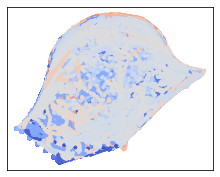

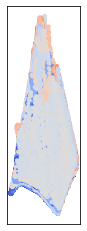

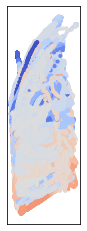

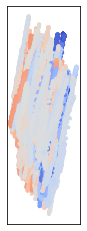

In [27]:
fig = plt.figure(figsize=(17,3))
cols=4
for i in range(cols):
  plt.subplot(1, cols, i+1)
  plt.scatter(transformed[:,i], transformed[:,i+1], c=_df.pm.values, cmap=plt.get_cmap('coolwarm'),
              marker='.',vmin = _df['pm'].min(), vmax = _df['pm'].max())
  plt.tick_params(axis='both', which='both', bottom=False, top=False, labelbottom=False, right=False, left=False, labelleft=False)
  plt.show()






> - from here, We can see that no gaussian distributions are recognized.
> - nor is the target temperature distinguishable in the spatial dimension.
> - there is no good feature. this is needed to be found, different from the raw sensor data.

# Predictions from OLS(Ordinary Least Squares) and RF(Random Forest)

In [30]:
def evaluate_baseline(data):
  scaler = StandardScaler()

  scaled_data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
  trainset = scaled_data.loc[:,[c for c in data.columns if c not in ['profile_id']+target_features]]
  target = scaled_data.loc[:,'pm']


  ols = LinearRegression(fit_intercept=False)
  print('Start fitting OLS')
  scores = cross_val_score(ols,trainset, target, cv=5,scoring='neg_mean_squared_error')
  print(f'OLS MSE: {-scores.mean():.4f} (+/- {scores.std()*2:.3f})\n')

  rf = RandomForestRegressor(n_estimators = 20, n_jobs=-1)
  print('Start fitting RF...')
  scores = cross_val_score(rf, trainset, target, cv=5, scoring ='neg_mean_squared_error')

  print(f'RF MSE : {-scores.mean():.4f} (+/- {scores.std()*2:.3f})\n')







In [31]:
evaluate_baseline(df)

Start fitting OLS
OLS MSE: 0.4350 (+/- 0.136)

Start fitting RF...
RF MSE : 0.4959 (+/- 0.157)



In [32]:
spans = [6360,3360,1320,9480]

max_span = max(spans)
enriched_profiles=[]
for p_id, p_df in df.groupby(['profile_id']):
  target_df = p_df.loc[:,target_features].reset_index(drop=True)
  p_df=p_df.drop(target_features + ['profile_id'], axis=1).reset_index(drop=True)

  prepadding = pd.DataFrame(np.zeros((max_span, len(p_df.columns))), columns = p_df.columns)
  temperature_cols = [c for c in ['ambient','coolant'] if c in df]
  prepadding.loc[:,temperature_cols]=p_df.loc[0, temperature_cols].values

  prepadded_df = pd.concat([prepadding, p_df], axis=0, ignore_index=True)
  ewma = pd.concat([prepadded_df.ewm(span=s).mean().rename(columns=lambda c:f'{c}_ewma_{s}') for s in spans], axis=1).astype(np.float32)
  ewma = ewma.iloc[max_span:,:].reset_index(drop=True)

  assert len(p_df) == len(ewma) == len(target_df), f'{len(p_df)}, {len(ewma)}, {len(target_df)} do not match'
  new_p_df = pd.concat([p_df, ewma, target_df], axis=1)
  new_p_df['profile_id'] = p_id
  enriched_profiles.append(new_p_df.dropna())
  enriched_df = pd.concat(enriched_profiles, axis=0,ignore_index=True)

  p_ids = enriched_df.pop('profile_id')






In [33]:
enriched_df.head()

u_q    coolant       u_d  motor_speed       i_d       i_q    ambient  \
0  4.921712  15.717488  0.051183    99.964539 -0.000385  0.000221  19.995035   
1  4.948537  15.890841  0.074807   100.017822 -0.002003  0.000886  19.954098   
2  4.941477  15.992567  0.063648    99.999977  0.000156 -0.000046  19.924765   
3  4.921178  16.135164  0.076738    99.980309  0.001466 -0.001133  19.903748   
4  4.924347  16.165384  0.084553   100.023392  0.000682  0.003452  19.888687   

     torque  u_q_ewma_6360  coolant_ewma_6360  ...  u_d_ewma_9480  \
0 -0.605463       0.001630          15.717488  ...       0.000012   
1 -0.613076       0.003269          15.717546  ...       0.000031   
2 -0.615070       0.004904          15.717637  ...       0.000046   
3 -0.617488       0.006532          15.717775  ...       0.000065   
4 -0.606528       0.008161          15.717923  ...       0.000086   

   motor_speed_ewma_9480  i_d_ewma_9480  i_q_ewma_9480  ambient_ewma_9480  \
0               0.024387  -9.383153e-08   5.398247e-08          19.995035   
1               0.048780  -5.825590e-07   2.701571e-07          19.995026   
2               0.073163  -5.442707e-07   2.589443e-07          19.995008   
3               0.097533  -1.866537e-07  -1.753691e-08          19.994986   
4               0.121908  -2.016031e-08   8.245317e-07          19.994961   

   torque_ewma_9480         pm  stator_tooth  stator_yoke  stator_winding  
0         -0.000148  23.153740     18.889385    18.395088       19.729197  
1         -0.000297  23.153469     18.895809    18.376493       19.737572  
2         -0.000447  23.147993     18.902767    18.371748       19.740677  
3         -0.000598  23.135658     18.908100    18.375002       19.727468  
4         -0.000746  23.137959     18.876144    18.378679       19.730543  

[5 rows x 44 columns]